<a href="https://colab.research.google.com/github/shitote/dist-repo/blob/main/Hate_speech_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load in the data.

In [2]:
# hate dataset.
hate_df = pd.read_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/hate.csv", encoding='latin-1') # Try reading with 'latin-1' encoding
hate_df.head()

,content,label
0,Every Kenyan know what follows these signature...,1
1,Nyaglet mbwakni https://t.co/Uo5B1uZkuk,1
2,Between this two sneakers which one is fake? n...,1
3,"Naskia mkiita huyu kijana Joel Ogolla mbwakni,...",1
4,Mauru na timbaa mbwakni?? https://t.co/kycrejNRv0,1


In [3]:
# non_hate dataset
non_hate_df = pd.read_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/non_hate.csv", encoding='latin-1')
non_hate_df.head()

,Content,label
0,Ijumaaa yetu imefika wana Simba!! Nunua tiketi...,0
1,Mwana Simba hakikisha mechi ya kesho kwa namna...,0
2,Rasmi leo najitangaza kuwa mimi ndo Msemaji bo...,0
3,Wana Simba tuje kwa wingi Uwanjani Ijumaa tush...,0
4,Konde Boy pekee anaeweza kwenda UTO ni yule al...,0


In [4]:
# Rename column for non_hate dataset
non_hate_df.rename(columns={'Content': 'content'}, inplace=True)
non_hate_df.head()

,content,label
0,Ijumaaa yetu imefika wana Simba!! Nunua tiketi...,0
1,Mwana Simba hakikisha mechi ya kesho kwa namna...,0
2,Rasmi leo najitangaza kuwa mimi ndo Msemaji bo...,0
3,Wana Simba tuje kwa wingi Uwanjani Ijumaa tush...,0
4,Konde Boy pekee anaeweza kwenda UTO ni yule al...,0


In [5]:
# Concatinate datasets
swahili_df = pd.concat([hate_df, non_hate_df], axis=0)
swahili_df.head()

,content,label
0,Every Kenyan know what follows these signature...,1
1,Nyaglet mbwakni https://t.co/Uo5B1uZkuk,1
2,Between this two sneakers which one is fake? n...,1
3,"Naskia mkiita huyu kijana Joel Ogolla mbwakni,...",1
4,Mauru na timbaa mbwakni?? https://t.co/kycrejNRv0,1


In [6]:
swahili_df.rename(columns={'content': 'text'}, inplace=True)
swahili_df.head()

,text,label
0,Every Kenyan know what follows these signature...,1
1,Nyaglet mbwakni https://t.co/Uo5B1uZkuk,1
2,Between this two sneakers which one is fake? n...,1
3,"Naskia mkiita huyu kijana Joel Ogolla mbwakni,...",1
4,Mauru na timbaa mbwakni?? https://t.co/kycrejNRv0,1


## Data Cleaning and Preprocessing

## Lowacasing all the letters

In [7]:
swahili_df['text'] = swahili_df['text'].str.lower()
swahili_df.head()

,text,label
0,every kenyan know what follows these signature...,1
1,nyaglet mbwakni https://t.co/uo5b1uzkuk,1
2,between this two sneakers which one is fake? n...,1
3,"naskia mkiita huyu kijana joel ogolla mbwakni,...",1
4,mauru na timbaa mbwakni?? https://t.co/kycrejnrv0,1


## Remove hastags and mentions

In [8]:
import re

In [9]:
swahili_df['text'] =swahili_df['text'].apply(str)
swahili_df.head()

,text,label
0,every kenyan know what follows these signature...,1
1,nyaglet mbwakni https://t.co/uo5b1uzkuk,1
2,between this two sneakers which one is fake? n...,1
3,"naskia mkiita huyu kijana joel ogolla mbwakni,...",1
4,mauru na timbaa mbwakni?? https://t.co/kycrejnrv0,1


In [10]:
# Remove all mentions.
swahili_df['text'] = swahili_df.apply(lambda row: re.sub("@[A-Za-z0-9_]+","", row['text']),axis=1)
swahili_df.head()

,text,label
0,every kenyan know what follows these signature...,1
1,nyaglet mbwakni https://t.co/uo5b1uzkuk,1
2,between this two sneakers which one is fake? n...,1
3,"naskia mkiita huyu kijana joel ogolla mbwakni,...",1
4,mauru na timbaa mbwakni?? https://t.co/kycrejnrv0,1


In [11]:
# Remove all hashtags
swahili_df['text'] = swahili_df.apply(lambda row: re.sub("#[A-Za-z0-9_]+","", row['text']),axis=1)
swahili_df.head()

,text,label
0,every kenyan know what follows these signature...,1
1,nyaglet mbwakni https://t.co/uo5b1uzkuk,1
2,between this two sneakers which one is fake? n...,1
3,"naskia mkiita huyu kijana joel ogolla mbwakni,...",1
4,mauru na timbaa mbwakni?? https://t.co/kycrejnrv0,1


## Removing links

In [12]:
# Remove https links
swahili_df['text'] = swahili_df.apply(lambda row: re.sub(r"http\S+","", row['text']),axis=1)
swahili_df.head()

,text,label
0,every kenyan know what follows these signature...,1
1,nyaglet mbwakni,1
2,between this two sneakers which one is fake? n...,1
3,"naskia mkiita huyu kijana joel ogolla mbwakni,...",1
4,mauru na timbaa mbwakni??,1


In [13]:
# Remove www. links
swahili_df['text'] = swahili_df.apply(lambda row: re.sub(r"www. \S+","", row['text']),axis=1)
swahili_df.head()

,text,label
0,every kenyan know what follows these signature...,1
1,nyaglet mbwakni,1
2,between this two sneakers which one is fake? n...,1
3,"naskia mkiita huyu kijana joel ogolla mbwakni,...",1
4,mauru na timbaa mbwakni??,1


## Removing the punctuations

In [14]:
swahili_df['text'] = swahili_df.apply(lambda row: re.sub('[()!?]'," ", row['text']),axis=1)
swahili_df.head()

,text,label
0,every kenyan know what follows these signature...,1
1,nyaglet mbwakni,1
2,between this two sneakers which one is fake n...,1
3,"naskia mkiita huyu kijana joel ogolla mbwakni,...",1
4,mauru na timbaa mbwakni,1


In [15]:
swahili_df['text'] = swahili_df.apply(lambda row: re.sub('\[.*?\]'," ", row['text']),axis=1)
swahili_df.head()

,text,label
0,every kenyan know what follows these signature...,1
1,nyaglet mbwakni,1
2,between this two sneakers which one is fake n...,1
3,"naskia mkiita huyu kijana joel ogolla mbwakni,...",1
4,mauru na timbaa mbwakni,1


In [16]:
## Removing all non-alphanumeric characters
swahili_df['text'] = swahili_df.apply(lambda row: re.sub("[^a-zA-Z0-9]"," ", row['text']),axis=1)
swahili_df.head()

,text,label
0,every kenyan know what follows these signature...,1
1,nyaglet mbwakni,1
2,between this two sneakers which one is fake n...,1
3,naskia mkiita huyu kijana joel ogolla mbwakni ...,1
4,mauru na timbaa mbwakni,1


In [17]:
# remove blank text rows
print("Total length before cleaning:", len(swahili_df))

blank_rows = swahili_df['text'].str.strip().eq('').fillna(True)
swahili_df = swahili_df[~blank_rows]

print("Total length after cleaning:", len(swahili_df))

Total length before cleaning: 48618
Total length after cleaning: 47726


## Checke and removeing all the duplicate values form the dataset

In [18]:
 # check for the total af duplicate values.
swahili_df['text'].duplicated().sum()

6229

In [19]:
# Remove duplicate values on the text column
swahili_df.drop_duplicates(subset=['text'], inplace=True)
swahili_df.head()

,text,label
0,every kenyan know what follows these signature...,1
1,nyaglet mbwakni,1
2,between this two sneakers which one is fake n...,1
3,naskia mkiita huyu kijana joel ogolla mbwakni ...,1
4,mauru na timbaa mbwakni,1


In [20]:
swahili_df['text'].duplicated().sum()

0

In [21]:
len(swahili_df)

41497

## Removing numerical values

In [22]:
def cleaning_number(data):
  return re.sub('[0-9]+', '', data)

swahili_df['text']= swahili_df['text'].apply(lambda x: cleaning_number(x))
swahili_df.head()

,text,label
0,every kenyan know what follows these signature...,1
1,nyaglet mbwakni,1
2,between this two sneakers which one is fake n...,1
3,naskia mkiita huyu kijana joel ogolla mbwakni ...,1
4,mauru na timbaa mbwakni,1


In [23]:
# Save the data
swahili_df.to_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/cleaned_swahili_df.csv", index=False)

In [24]:
# Load in the Cleaned dataset
cleaned_df = pd.read_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/cleaned_swahili_df.csv")
cleaned_df.head(), len(cleaned_df)

(                                                text label
 0  every kenyan know what follows these signature...     1
 1                                   nyaglet mbwakni      1
 2  between this two sneakers which one is fake  n...     1
 3  naskia mkiita huyu kijana joel ogolla mbwakni ...     1
 4                         mauru na timbaa mbwakni        1,
 41497)

## EDA

### Define and remove all the stop words in Kiswahili and English

In [25]:
cleaned_df.head()

,text,label
0,every kenyan know what follows these signature...,1
1,nyaglet mbwakni,1
2,between this two sneakers which one is fake n...,1
3,naskia mkiita huyu kijana joel ogolla mbwakni ...,1
4,mauru na timbaa mbwakni,1


In [26]:
# Check for duplicate based on text column
duplicate_rows = cleaned_df.duplicated(subset=['text'])

# Count the number of duplicates
num_duplicates = duplicate_rows.sum()

print("Number of duplicate rows:", num_duplicates)
print(len(cleaned_df))
cleaned_df = cleaned_df.drop_duplicates(subset=['text'])
print(len(cleaned_df))

Number of duplicate rows: 170
41497
41327


In [27]:
cleaned_df.head()

,text,label
0,every kenyan know what follows these signature...,1
1,nyaglet mbwakni,1
2,between this two sneakers which one is fake n...,1
3,naskia mkiita huyu kijana joel ogolla mbwakni ...,1
4,mauru na timbaa mbwakni,1


In [28]:
eng_stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'wewe', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [29]:
STOPWORDS = set(eng_stopwordlist)
def cleaning_stopwords(text, stopwords):
  return " ".join([word for word in str(text).split() if word not in stopwords])
cleaned_df['text'] = cleaned_df['text'].apply(lambda text: cleaning_stopwords(text, STOPWORDS))
cleaned_df.head()

,text,label
0,every kenyan know follows signature lip moveme...,1
1,nyaglet mbwakni,1
2,two sneakers one fake ni gani mbwakni white am...,1
3,naskia mkiita huyu kijana joel ogolla mbwakni ...,1
4,mauru na timbaa mbwakni,1


### Removing white white spaces.

In [30]:
def remove_whitespace(text):
  return " ".join(text.split())
cleaned_df['text'] = cleaned_df['text'].apply(lambda text: remove_whitespace(text))
cleaned_df.head(10)

,text,label
0,every kenyan know follows signature lip moveme...,1
1,nyaglet mbwakni,1
2,two sneakers one fake ni gani mbwakni white am...,1
3,naskia mkiita huyu kijana joel ogolla mbwakni ...,1
4,mauru na timbaa mbwakni,1
5,kenyan promoters huwa mbwakni sana,1
6,arsenali oeeee team mbwakni kabisaa,1
7,fuck finance bill,1
8,kwanza hizo yeezy slides zako ni mbwakni sijas...,1
9,ukinunua laptop luthuli alafu upate ni mbwakni...,1


In [31]:
swahili_stopwords = pd.read_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/swahili_stopwords.csv")
len(swahili_stopwords)

255

In [32]:
swa_stopwords = swahili_stopwords['StopWords'].tolist()

In [33]:
# Remove all swahili stopewords
STOPWORDS = set(swa_stopwords)
cleaned_df['text'] = cleaned_df['text'].apply(lambda text: cleaning_stopwords(text, STOPWORDS))
cleaned_df.head()

,text,label
0,every kenyan know follows signature lip moveme...,1
1,nyaglet mbwakni,1
2,two sneakers one fake gani mbwakni white gray,1
3,naskia mkiita huyu kijana joel ogolla mbwakni ...,1
4,mauru timbaa mbwakni,1


In [34]:
# save the dataset again
cleaned_df.to_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/swahili_nostop_df.csv")

### Removing most used words.

In [35]:
from collections import Counter
count = Counter()
for text in cleaned_df["text"].values:
    for word in text.split():
        count[word] += 1
count.most_common(10)

[('watu', 2820),
 ('mtu', 1931),
 ('leo', 1907),
 ('kuna', 1784),
 ('wako', 1499),
 ('ndio', 1469),
 ('tanzania', 1453),
 ('rais', 1431),
 ('serikali', 1424),
 ('siku', 1308)]

In [36]:
FREQWORDS = set([w for (w, wc) in count.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])
cleaned_df["text"] = cleaned_df["text"].apply(lambda text: remove_freqwords(text))
cleaned_df.head()

,text,label
0,every kenyan know follows signature lip moveme...,1
1,nyaglet mbwakni,1
2,two sneakers one fake gani mbwakni white gray,1
3,naskia mkiita huyu kijana joel ogolla mbwakni ...,1
4,mauru timbaa mbwakni,1


### Plot a cloud of words for hate tweets

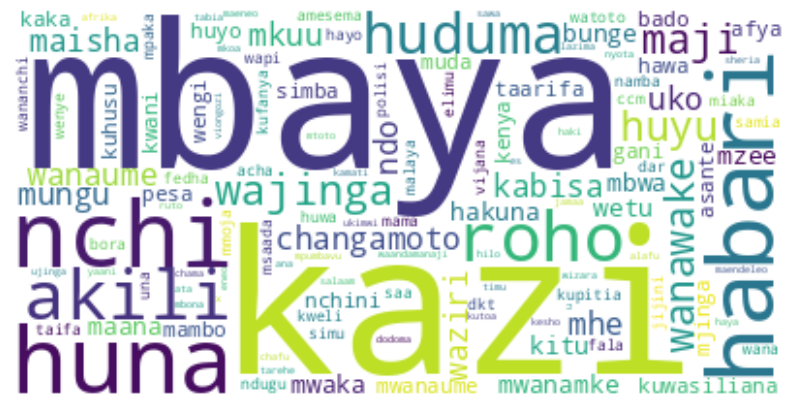

In [37]:
%matplotlib inline
from wordcloud import WordCloud
text = " ".join(" ".join(cat) if isinstance(cat, list) else cat for cat in cleaned_df.text)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
plt.figure(figsize = (10, 10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [38]:
# Check if the dataset is balanced
cleaned_df['label'].value_counts()

label
0    22091
1    19235
o        1
Name: count, dtype: int64

In [39]:
cleaned_df = cleaned_df.drop(cleaned_df[cleaned_df['label'] == 'o'].index)

In [40]:
cleaned_df['label'].value_counts()

label
0    22091
1    19235
Name: count, dtype: int64

In [41]:
# Shuffle the dataset
cleaned_df_shuffled = cleaned_df.sample(frac=1).reset_index(drop=True)
cleaned_df_shuffled.head()

,text,label
0,kuhamasisha wazuri maandamano hatuwaoni wakiji...,1
1,ivi wanawake kwanini wawekewe sheria waingie t...,0
2,ukilonga mqchoka dakika umechoka mchawi aliyek...,1
3,pullop bima munga mjinga najua lunch mwanaume ...,1
4,naskia mzee kitendawili anaamka sita,1


In [42]:
cleaned_df_shuffled.label.value_counts()

label
0    22091
1    19235
Name: count, dtype: int64

In [43]:
print(cleaned_df_shuffled['text'].dtypes)

object


In [44]:
#save the shuffled data
cleaned_df_shuffled.to_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/shuffled_swahili_df.csv", index=False)

In [45]:
# Visualize random traning examples.
import random
random_index = random.randint(0, len(cleaned_df_shuffled))
for row in cleaned_df_shuffled[['text', 'label']][random_index:random_index+5].itertuples():
  _, text, label = row
  # Convert label to integer before comparison
  print(f'Labels: {label}', '(hate_speech)' if int(label) > 0 else '(Note hate_speech)')
  print(f'Text:\n{text}\n')
  print("----------------------\n")

Labels: 1 (hate_speech)
Text:
kwani kilema mahali itabidi ujaribu monopoly

----------------------

Labels: 0 (Note hate_speech)
Text:
trust waziri shall make right decision people earn living twitter use educational purposes others get information citizen journalism therefore ban infringe rights people information kaka ukiwa kiongozi wananchi viongozi wanao tumia mtandao jaribu kuwaambia viongozi ccm wabadilike

----------------------

Labels: 1 (hate_speech)
Text:
tatizo wanawake wengi mnakuwa wavivu kutafuta wanaume wachafu mkawapendesha mnataka wanaong ara hamjui km wanang arishwa mwanamke mwenzako

----------------------

Labels: 1 (hate_speech)
Text:
huyu mjinga katokea wapi inaonekana hana uelewa hiki kinachopingwa mdini kawaida woalivyo wadini

----------------------

Labels: 1 (hate_speech)
Text:
kumanina dear malayo embizi gwe

----------------------



### Split the dataset into training and validation datasets

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
# Slipt the dataset
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    cleaned_df_shuffled['text'].to_numpy(),
    cleaned_df_shuffled['label'].to_numpy(),
    test_size=0.1,
    random_state=42
)
len(train_sentences), len(test_sentences)

(37193, 4133)

In [48]:
train_sentences[:5], train_labels[:5]

(array(['limejaa linakwenda kujaa punde simba tunakwenda zambia',
        'unakula mbwa koko but ready spend ukanunue majani fito ule asubuhi addicts amaze bro',
        'soon soon rigathi going discover ule mzee kitendawili least problems gov eats prophet orengo',
        'ati mmesema kbc hukuwa vienyeji sector tv channels',
        'sema huyo helmina muacheni jamen'], dtype=object),
 array(['0', '1', '1', '1', '0'], dtype=object))

## Convert Text to Numbers.

* Tokenization - Direxct mapping of tokens to numbers
* Embedding - Mapping of words to vectors

### Text Vectorization(Tokenization)

In [49]:
len(train_sentences[0]. split())

7

In [50]:
# Find the average number of tokens in the training datasets.
round(sum([len(str(i).split()) for i in train_sentences])/len(train_sentences))

12

In [51]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# set text vexctorization variables
max_vocab_lenght = 2000
max_length = 18

text_vectorizer = TextVectorization(max_tokens=max_vocab_lenght,
                                    output_mode='int',
                                    output_sequence_length=max_length,
                                    )

In [52]:
# Fit the vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [53]:
# Tokenize a sample sentence
sample_sentence = "huna heshima kabisa"
text_vectorizer(sample_sentence)

<tf.Tensor: shape=(18,), dtype=int64, numpy=
array([  4, 187,  12,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0])>

In [54]:
# choose a random sentence from the training sentences
random_sentence = random.choice(train_sentences)
print(f'Original text: \n {random_sentence}\n\n Vectorized version:')
text_vectorizer([random_sentence])

Original text: 
 maisha unayaona magumu kwasababu huna uzoefu maisha mengine yapo maisha ukiyapitia utamshukuru mungu ulivyo good morning

 Vectorized version:


<tf.Tensor: shape=(1, 18), dtype=int64, numpy=
array([[  16,    1,  997,  453,    4, 1644,   16,  636,    1,   16,    1,
           1,   20, 1767,  181,  332,    0,    0]])>

In [55]:
# Get unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:10]
bottom_5_words = words_in_vocab[-5:]
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'10 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in vocab: 2000
10 most common words: ['', '[UNK]', 'mbaya', 'kazi', 'huna', 'nchi', 'habari', 'akili', 'roho', 'huduma']
5 least common words: ['supporting', 'stay', 'stand', 'shaka', 'saana']


### Create an Embedding

In [56]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_lenght,
                             output_dim=128,
                             input_length=max_length)
embedding

In [57]:
# visualize after embedding
print(f'Original text: \n {random_sentence} \
      \n\nEmbedded version: ')
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text: 
 maisha unayaona magumu kwasababu huna uzoefu maisha mengine yapo maisha ukiyapitia utamshukuru mungu ulivyo good morning       

Embedded version: 


<tf.Tensor: shape=(1, 18, 128), dtype=float32, numpy=
array([[[-0.04773858,  0.03178987, -0.02066987, ..., -0.02892604,
         -0.03317098,  0.03266838],
        [ 0.01593033,  0.04558371,  0.00286634, ..., -0.0153285 ,
          0.0039103 ,  0.04111433],
        [-0.0289953 ,  0.02019305,  0.01047212, ...,  0.01674812,
         -0.01414936,  0.0299116 ],
        ...,
        [-0.00546331, -0.00094279,  0.00363051, ...,  0.024732  ,
          0.04268329, -0.02358449],
        [ 0.01921466,  0.02782792, -0.04125615, ...,  0.04267032,
          0.04015249,  0.03376   ],
        [ 0.01921466,  0.02782792, -0.04125615, ...,  0.04267032,
          0.04015249,  0.03376   ]]], dtype=float32)>

## Modeling
### Baseline model

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [59]:
# Create a data pipeline
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [60]:
# Baseline model evaluation
baseline_score = model_0.score(test_sentences, test_labels)
print(f"baseline model score: {baseline_score*100:.2f}%")

baseline model score: 86.91%


In [61]:
# Make predictions
baseline_preds = model_0.predict(test_sentences)
baseline_preds[:20]

array(['1', '0', '0', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1',
       '0', '1', '1', '0', '0', '1', '0'], dtype='<U1')

In [62]:
test_sentences[:20]

array(['nilichoka aliposema mwanangu mapenzi baadae punda',
       'tusipotoshe hiki ndicho alichokisema mhe samia kuhusu utoaji chanjo majumbani waelimishwe kuhusu kupokea chanjo wakubali kuchoma hiari',
       'noma kaka',
       'shekhe bwege flani mpumbavu mmoja tumbo tumbo tumbo njaaa aaaa',
       'ujenzi isongole isoko km inalipa fidia wakazi kata bupigu wilaya ileje mkoani mbeya kupisha ujenzi isongole isoko yenye urefu kilomita awamu',
       'tangamjini',
       'propaganda gani unajua tofauti useme wapi tumesema wasiende kupiga kura tunataka wananchi wapige kura alafu walinde kura',
       'malaya punda die fool',
       'amr kids sickle cell disease uti attending clinic mnh screened antibiotic resistance patterns strains resistant ampiclox ampicillin erythromycin ceftriaxone studies needed check patterns paediatrics',
       'una shombooooo',
       'unajiuliza roho iliyo wanawake kusudi gan kuvaa nguo chafu mipasuo vimini nguo inaonesha maungo unajiuliza n nn roho kizinzi 

In [63]:
# Model Evaluation based on: accuracy score, precision score, recall, f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall and f1 score of a binary classification model.
  """
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(
      y_true,
      y_pred,
      average="weighted")
  model_results = {
      "accuracy": model_accuracy,
      "precision": (model_precision)*100,
      "recall": (model_recall)*100,
      "f1": (model_f1)*100
  }
  return model_results


In [64]:
# Make results.
baseline_results = calculate_results(test_labels, baseline_preds)
baseline_results

{'accuracy': 86.91023469634648,
 'precision': 87.54756864147572,
 'recall': 86.91023469634648,
 'f1': 86.93315555490183}

### SVM

**A support vector machine (SVM) is a machine learning algorithm that uses supervised learning models to solve complex classification, regression, and outlier detection problems by performing optimal data transformations that determine boundaries between data points based on predefined classes, labels, or outputs. SVMs are widely adopted across disciplines such as healthcare, natural language processing, signal processing applications, and speech & image recognition fields**

In [65]:
%%time
from sklearn.linear_model import SGDClassifier
model_1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SGDClassifier())
])

# fit the model
model_1.fit(train_sentences, train_labels)

CPU times: user 731 ms, sys: 78.2 ms, total: 809 ms
Wall time: 791 ms


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', SGDClassifier())])

In [66]:
model_1.score(test_sentences, test_labels)

0.9421727558674087

In [67]:
# Make Predictions
model_1_preds = model_1.predict(test_sentences)
model_1_preds[:20]

array(['1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '1', '1',
       '0', '1', '1', '0', '0', '1', '0'], dtype='<U1')

In [68]:
model_1_results = calculate_results(y_true=test_labels,
                                     y_pred=model_1_preds)
model_1_results

{'accuracy': 94.21727558674087,
 'precision': 94.23018899933237,
 'recall': 94.21727558674087,
 'f1': 94.21033848946837}

In [69]:
# Find the classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, model_1_preds))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2249
           1       0.95      0.92      0.94      1884

    accuracy                           0.94      4133
   macro avg       0.94      0.94      0.94      4133
weighted avg       0.94      0.94      0.94      4133



### ⏳Search for optimal parameters for SVM algotithm

In [70]:
# Vectorize the text data.
%%time
tfv = TfidfVectorizer(analyzer='word',
                      ngram_range=(1, 3), use_idf=1, smooth_idf=1,
                      sublinear_tf=1)
tfv.fit(pd.concat([pd.Series(train_sentences), pd.Series(test_sentences)]))
x_train_tfv = tfv.transform(train_sentences)
x_test_tfv = tfv.transform(test_sentences)

x_train_tfv.shape, x_test_tfv.shape

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


CPU times: user 5.26 s, sys: 193 ms, total: 5.45 s
Wall time: 5.5 s


((37193, 772502), (4133, 772502))

In [71]:
from sklearn import svm

In [72]:
X = x_train_tfv
y = cleaned_df_shuffled['label']

In [73]:
# %%time
# kernels = ['linear', 'rbf', 'poly', 'sigmoid']
# for kernel in kernels:
#   svc = svm.SVC(kernel=kernel)
#   svc.fit(x_train_tfv, train_labels)
#   # Move the plot function inside the loop to have access to the fitted svc object
#   # Create a mesh to plot in
#   x_min, x_max = x_train_tfv[:, 0].min() - 1, x_train_tfv[:, 0].max() + 1 # Use x_train_tfv for dimensions
#   y_min, y_max = x_train_tfv[:, 1].min() - 1, x_train_tfv[:, 1].max() + 1 # Use x_train_tfv for dimensions
#   h = (x_max - x_min)/100
#   xx , yy = np.meshgrid(np.arange(x_min, x_max, h),
#                         np.arange(y_min, y_max, h))
#   plt.subplot(1, 1, 1)
#   Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
#   Z = Z.reshape(xx.shape)
#   plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
#   plt.scatter(x_train_tfv[:, 0], x_train_tfv[:, 1], c=train_labels, cmap=plt.cm.Paired) # Use training data for plotting
#   plt.xlabel('Sepal length')
#   plt.ylabel('Sepal width')
#   plt.xlim(xx.min(), xx.max())
#   plt.ylim(yy.min(), yy.max())
#   plt.xticks(())
#   plt.yticks(())
#   plt.title('kernel=' + str(kernel)) # Set the title for each plot
#   plt.show()

### Logistic regresion
**Logistic Regression is a “Supervised machine learning” algorithm that can be used to model the probability of a certain class or event. It is used when the data is linearly separable and the outcome is binary or dichotomous in nature.**


In [74]:
from sklearn.linear_model import LogisticRegression
model_logisctic = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

model_logisctic.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])

In [75]:
# find the model score
model_logisctic.score(test_sentences, test_labels)

0.9383014759254779

In [76]:
# make predictins
model_logisctic_preds = model_logisctic.predict(test_sentences)
model_logisctic_preds[:20]

array(['1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '1', '1',
       '0', '1', '1', '0', '0', '1', '0'], dtype=object)

In [77]:
# model evaluation
model_logisctic_results = calculate_results(y_true=test_labels,
                                             y_pred=model_logisctic_preds)
model_logisctic_results

{'accuracy': 93.83014759254779,
 'precision': 93.83787918857959,
 'recall': 93.83014759254779,
 'f1': 93.82374839356366}

#### ⌛ Logistic regression hyperparameters

In [78]:
from sklearn.model_selection import GridSearchCV
small_param_grid = [
    {
        'tfidf__ngram_range': [(1, 1)],
        'tfidf__stop_words': [None],
        'tfidf__tokenizer': [None],
        'tfidf__use_idf': [False],
        'tfidf__norm': [None],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    {
        'tfidf__ngram_range': [(1, 1)],
        'tfidf__stop_words': [None],
        'tfidf__tokenizer': [None],
        'tfidf__use_idf': [False],
        'tfidf__norm': [None],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }
]

lr_grid_search = GridSearchCV(model_logisctic, small_param_grid,
                              cv=5,
                              scoring='accuracy',
                              verbose=True)
lr_grid_search.fit(train_sentences, train_labels)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', LogisticRegression())]),
             param_grid=[{'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'clf__penalty': ['l1', 'l2'],
                          'tfidf__ngram_range': [(1, 1)], 'tfidf__norm': [None],
                          'tfidf__stop_words': [None],
                          'tfidf__tokenizer': [None],
                          'tfidf__use_idf': [False]},
                         {'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'clf__penalty': ['l1', 'l2'],
                          'tfidf__ngram_range': [(1, 1)], 'tfidf__norm': [None],
                          'tfidf__stop_words': [None],
                          'tfidf__tokenizer': [None],
                          'tfidf__use_idf': [False]}],
             scoring='accuracy', verbose=True)

In [79]:
# score the model
lr_grid_search.score(test_sentences, test_labels)

0.9520929107186064

In [80]:
# make predictions
lr_grid_search_preds = lr_grid_search.predict(test_sentences)
lr_grid_search_preds[:10]

array(['1', '0', '0', '1', '0', '0', '0', '1', '0', '0'], dtype=object)

In [81]:
# evaluate the model
lr_grid_search_results = calculate_results(y_true=test_labels,
                                           y_pred=lr_grid_search_preds)
lr_grid_search_results

{'accuracy': 95.20929107186063,
 'precision': 95.220918092382,
 'recall': 95.20929107186063,
 'f1': 95.20419402099897}

In [82]:
# Find the best params
lr_grid_search.best_params_

{'clf__C': 1,
 'clf__penalty': 'l2',
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': None,
 'tfidf__stop_words': None,
 'tfidf__tokenizer': None,
 'tfidf__use_idf': False}

### Decision Tree

**Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.**

In [83]:
# DT model initialization and training.
%%time
from sklearn.tree import DecisionTreeClassifier

model_dt = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier())
])
model_dt.fit(train_sentences, train_labels)

CPU times: user 28.5 s, sys: 10.6 ms, total: 28.5 s
Wall time: 30 s


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', DecisionTreeClassifier())])

In [84]:
# score the model
model_dt.score(test_sentences, test_labels)

0.9373336559399952

In [85]:
# make predictions
model_dt_preds = model_dt.predict(test_sentences)
model_dt_preds[:10]

array(['1', '0', '0', '1', '0', '0', '0', '1', '0', '0'], dtype=object)

In [86]:
test_labels[:10]

array(['1', '0', '0', '1', '0', '0', '0', '1', '0', '0'], dtype=object)

In [87]:
# Evaluate the dt model
model_dt_results = calculate_results(y_true=test_labels,
                                     y_pred=model_dt_preds)
model_dt_results

{'accuracy': 93.73336559399952,
 'precision': 93.73159898377088,
 'recall': 93.73336559399952,
 'f1': 93.73154762387288}

In [88]:
# comapre the cost-complexity prunning path
%%time
tree_model = model_dt.named_steps['clf']
path = tree_model.cost_complexity_pruning_path(x_train_tfv, train_labels)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

CPU times: user 3min 17s, sys: 0 ns, total: 3min 17s
Wall time: 3min 18s


Text(0.5, 1.0, 'Total Impurity vs Effective alpha for training set')

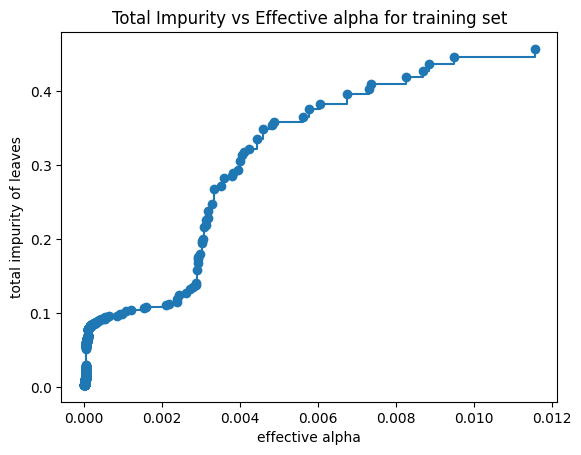

In [89]:
# plot the pruning path
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle='steps-post')
ax.set_xlabel('effective alpha')
ax.set_ylabel('total impurity of leaves')
ax.set_title('Total Impurity vs Effective alpha for training set')

In [90]:
#nfind the optimal value for ccp_alpha
optimal_ccp_alpha = ccp_alphas[np.argmin(impurities)]
optimal_ccp_alpha

0.0

In [91]:
%%time
tree_model.set_params(ccp_alpha=optimal_ccp_alpha)
tree_model = tree_model.fit(x_train_tfv, train_labels)

CPU times: user 3min 24s, sys: 0 ns, total: 3min 24s
Wall time: 3min 25s


In [92]:
# tree model score
tree_model.score(x_test_tfv, test_labels)

0.941930800871038

In [93]:
# make predictions
tree_model_preds = tree_model.predict(x_test_tfv)
tree_model_preds[:10]

array(['1', '0', '0', '1', '0', '0', '0', '1', '0', '0'], dtype=object)

In [94]:
# evaluate the model
tree_model_results = calculate_results(y_true=test_labels,
                                       y_pred=tree_model_preds)
tree_model_results

{'accuracy': 94.1930800871038,
 'precision': 94.19157903264906,
 'recall': 94.1930800871038,
 'f1': 94.19152924955631}

### RandomForestClassifier

In [95]:
%%time
from sklearn.ensemble import RandomForestClassifier
model_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])
model_rf.fit(train_sentences, train_labels)

CPU times: user 2min 1s, sys: 0 ns, total: 2min 1s
Wall time: 2min 2s


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])

In [96]:
# Random forest model score
model_rf_score = model_rf.score(test_sentences, test_labels)
print(f"Random forest model score: {model_rf_score*100:.2f}%")

Random forest model score: 94.77%


In [97]:
model_rf_score = model_rf.score(train_sentences, train_labels)
print(f"Random forest model score: {model_rf_score*100:.2f}%")

Random forest model score: 99.80%


In [98]:
# Make predictions
model_rf_preds = model_rf.predict(test_sentences)
model_rf_preds[:10]

array(['1', '0', '0', '1', '0', '0', '0', '1', '0', '0'], dtype=object)

In [99]:
# Evaluate the model
model_rf_results = calculate_results(y_true=test_labels,
                                     y_pred=model_rf_preds)
model_rf_results

{'accuracy': 94.77377207839342,
 'precision': 94.776247522613,
 'recall': 94.77377207839342,
 'f1': 94.77465245444945}

In [100]:
model_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs= -1, random_state=42))
])
model_rf.fit(train_sentences, train_labels)
model_rf_score = model_rf.score(test_sentences, test_labels)
print(f"Random forest model score: {model_rf_score*100:.2f}%")

Random forest model score: 94.87%


### KNN
**The k-nearest neighbors (KNN) algorithm is a non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point. It is one of the popular and simplest classification and regression classifiers used in machine learning today.**

In [101]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', KNeighborsClassifier())
])
model_knn.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', KNeighborsClassifier())])

In [102]:
# score the model.
model_knn_score = model_knn.score(test_sentences, test_labels)
print(f"KNN model score: {model_knn_score}")

KNN model score: 0.642632470360513


## Deep Modeling

### Single dence layer

In [103]:
# singl dence layer model using functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x= embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name='Model_1_dense')

In [104]:
# Show the model summary.
model_1.summary()

Model: "Model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 18)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 18, 128)           256000    
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 256129 (1000.50 KB)
Trainable params: 2

In [105]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [106]:
test_label_series = pd.Series(test_labels)
test_label_series.value_counts()

0    2249
1    1884
Name: count, dtype: int64

In [107]:
# fit the model.
%%time
test_label = test_labels.astype(int)
train_label = train_labels.astype(int)
model_1_history = model_1.fit(train_sentences,
                              train_label,
                              epochs=5,
                              validation_data=(test_sentences, test_label))


Epoch 1/5
1163/1163 [==============================] - 19s 14ms/step - loss: 0.3978 - accuracy: 0.8535 - val_loss: 0.2431 - val_accuracy: 0.9264
Epoch 2/5
1163/1163 [==============================] - 6s 5ms/step - loss: 0.2020 - accuracy: 0.9384 - val_loss: 0.1980 - val_accuracy: 0.9339
Epoch 3/5
1163/1163 [==============================] - 7s 6ms/step - loss: 0.1735 - accuracy: 0.9448 - val_loss: 0.1928 - val_accuracy: 0.9354
Epoch 4/5
1163/1163 [==============================] - 6s 5ms/step - loss: 0.1655 - accuracy: 0.9469 - val_loss: 0.1940 - val_accuracy: 0.9364
Epoch 5/5
1163/1163 [==============================] - 7s 6ms/step - loss: 0.1615 - accuracy: 0.9476 - val_loss: 0.1961 - val_accuracy: 0.9344
CPU times: user 48.7 s, sys: 3.49 s, total: 52.2 s
Wall time: 45.2 s


In [108]:
# evautate the model
model_1.evaluate(test_sentences, test_label)

130/130 [==============================] - 0s 3ms/step - loss: 0.1961 - accuracy: 0.9344


[0.19605785608291626, 0.9344301819801331]

In [109]:
# make predictions
model_1_pred_probs = model_1.predict(test_sentences)
print(model_1_pred_probs.shape)
print(model_1_pred_probs[0])

130/130 [==============================] - 0s 2ms/step
(4133, 1)
[0.991026]


In [110]:
# Convert the predicton probabilities into the label format.
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
       0., 1., 0.], dtype=float32)>

In [111]:
test_labels[:20]

array(['1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '1', '1',
       '0', '1', '1', '0', '0', '1', '0'], dtype=object)

### Recurrent Nural Network(RNN)
#### Model 1: LSTM

A long short-term memory network is a type of recurrent neural network (RNN).

* LSTMs are predominantly used to learn, process, and classify sequential data.
* They are user because these networks can learn long-term dependencies between time steps of data.

In [117]:
# Create an LSTM
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences= True)(x)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [118]:
# find the model summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 18)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 18, 128)           256000    
                                                                 
 lstm_2 (LSTM)               (None, 18, 64)            49408     
                                                                 
 lstm_3 (LSTM)               (None, 18, 64)            33024     
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                      

In [119]:
# Compile the model.
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [120]:
# Train and fit the model.
model_2_history = model_2.fit(train_sentences,
                              train_label,
                              epochs=5,
                              validation_data=(test_sentences, test_label))

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1163/1163 [==============================] - 39s 29ms/step - loss: 0.1347 - accuracy: 0.9567 - val_loss: 0.2248 - val_accuracy: 0.9310
Epoch 2/5
1163/1163 [==============================] - 23s 20ms/step - loss: 0.0925 - accuracy: 0.9700 - val_loss: 0.2506 - val_accuracy: 0.9308
Epoch 3/5
1163/1163 [==============================] - 27s 23ms/step - loss: 0.0769 - accuracy: 0.9750 - val_loss: 0.2816 - val_accuracy: 0.9318
Epoch 4/5
1163/1163 [==============================] - 17s 15ms/step - loss: 0.0694 - accuracy: 0.9770 - val_loss: 0.3191 - val_accuracy: 0.9228
Epoch 5/5
1163/1163 [==============================] - 19s 16ms/step - loss: 0.0655 - accuracy: 0.9784 - val_loss: 0.3210 - val_accuracy: 0.9315


In [121]:
# evaluate the model.
model_2.evaluate(test_sentences, test_label)

130/130 [==============================] - 2s 12ms/step - loss: 0.3210 - accuracy: 0.9315


[0.3209943175315857, 0.9315267205238342]

In [122]:
# Make predictions
model_2_pred_probs = model_2.predict(test_sentences)
print(model_2_pred_probs[0])

130/130 [==============================] - 2s 6ms/step
[0.9816969]


In [124]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 1., 0.], dtype=float32)>